# Predict the reverberation time from reverberant signals using linear regression

Author: Neil Zhang

Reverberation is the process of multi-path propagation of a sound from its source to one or more receivers. A reverberation is created when a sound or signal is reflected by the surfaces of objects and then decay as the surfaces absorbed the sound in the space. This problem is a straightforward machine learning task based on a tiny reverberation signals dataset. You will use the MFCC feature and the linear regression algorithm.

In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa
import IPython.display as ipd
from sklearn import linear_model
from sklearn.metrics import root_mean_squared_error

import pyroomacoustics as pra

methods = ["ism", "hybrid"]

fs, audio  = wavfile.read("../data/violin.wav")

In [2]:
ipd.Audio(audio, rate=fs)

In [3]:
def generate_rir(rt60_tgt):

    # input: The desired reverberation time 
    
    # dimensions of the room
    room_dim = [10, 7.5, 3.5]  # meters

    # import a mono wavfile as the source signal
    # the sampling frequency should match that of the room
    # fs, audio = wavfile.read("examples/samples/guitar_16k.wav")

    # We invert Sabine's formula to obtain the parameters for the ISM simulator
    e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

    room = pra.ShoeBox(
        room_dim,
        fs=fs,
        materials=pra.Material(e_absorption),
        max_order=3,
        ray_tracing=True,
        air_absorption=True,
        )

    # place the source in the room
    room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)
    room.add_source([2.5, 4.73, 1.76], signal=audio, delay=0.5)

    # define the locations of the microphones
    mic_locs = np.c_[
        [6.3, 4.87, 1.2],
        [6.3, 4.93, 1.2],  # mic 1  # mic 2
        [6.3, 4.98, 1.2],  # mic 1  # mic 2
    ]

    # finally place the array in the room
    room.add_microphone_array(mic_locs)

    # Run the simulation (this will also build the RIR automatically)
    room.simulate()

    return room.rir


In [4]:
rirs = generate_rir(3)

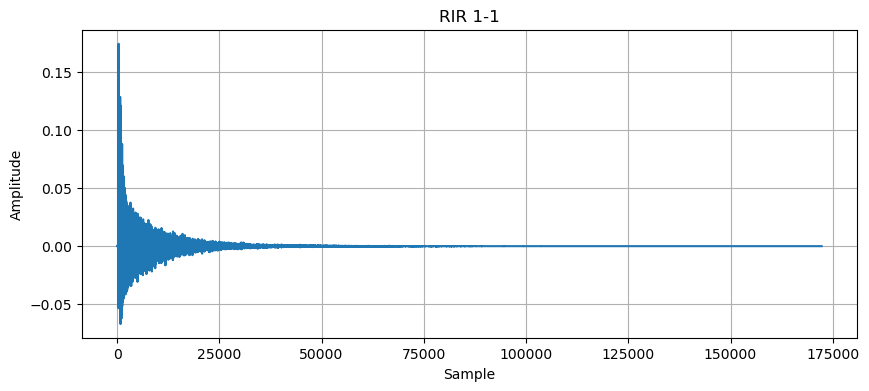

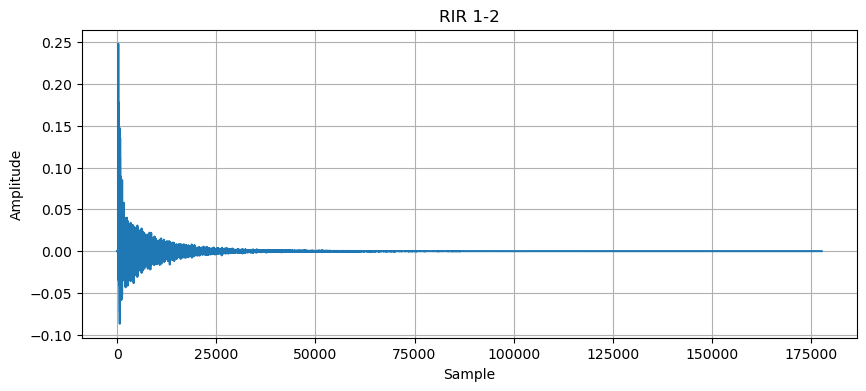

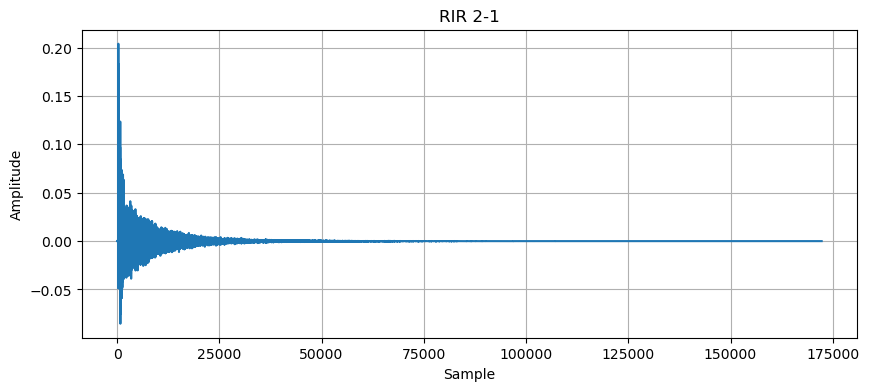

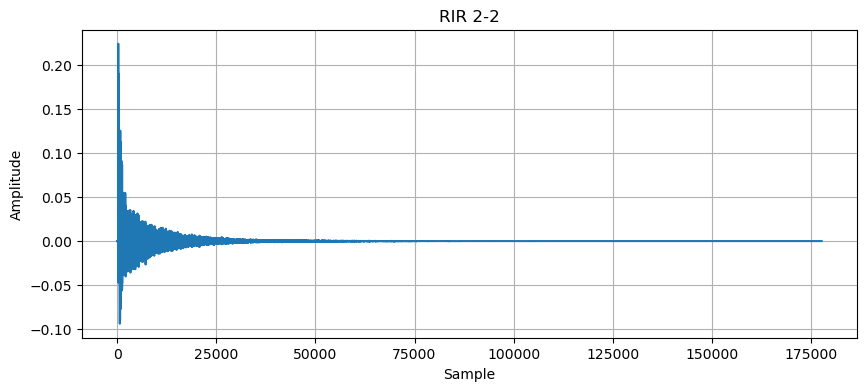

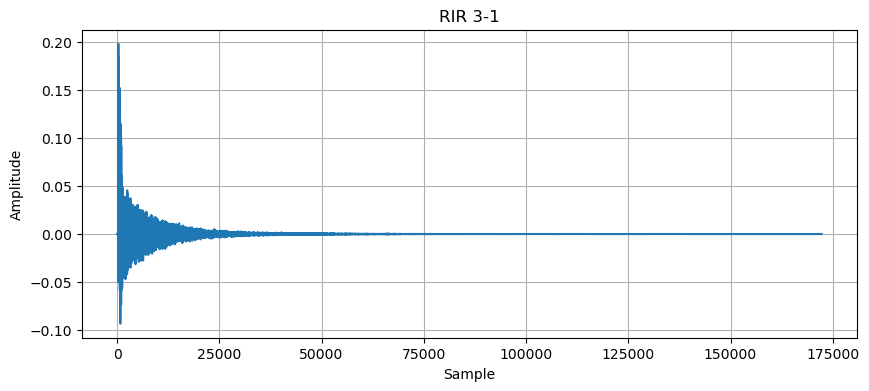

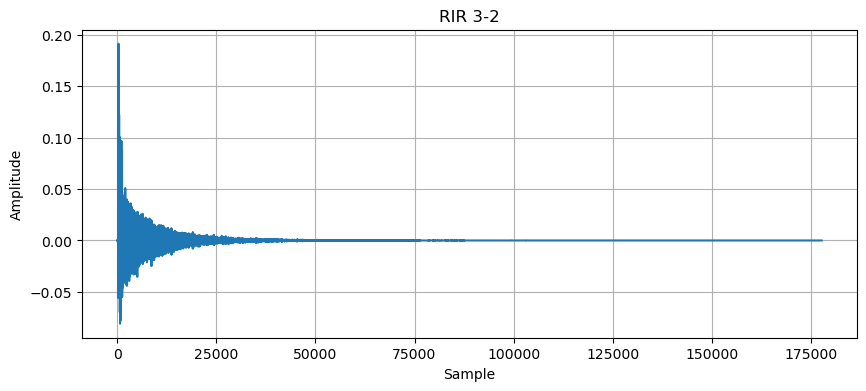

In [7]:
# Visualize the generated RIRs
for i in range(3):
    for j in range(2):
        plt.figure(figsize=(10, 4))
        plt.plot(rirs[i][j])
        plt.title(f'RIR {i+1}-{j+1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()

## Convolve with mono audio and extract MFCC features

In [5]:
X = []
y = []

for t60 in np.arange(0.6, 3, 0.2):
    rirs = generate_rir(t60)
    
    # convolve the audio file with the RIR
    for i in range(3):
        for j in range(2):
            out = np.convolve(audio[:3*fs], rirs[i][j])

            # get mfcc of first 3 seconds
            out = out[:3*fs]
            mfccs = librosa.feature.mfcc(y=out, sr=fs, n_mfcc=13) 
            mfccs_flattened = mfccs.flatten()

            X.append(mfccs_flattened)
            y.append(t60)


In [6]:
# play the reverberated audio
ipd.Audio(out, rate=fs)

## Generate data

In [7]:
X = np.array(X)
y = np.array(y)

# shuffle
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

## Split into training and test set

In [8]:
# split into train and test
X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]
X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(y)):]

## Fit a linear regression model with training data

In [9]:
regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

## Evaluate on test data

In [10]:
y_pred = regr.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print("Root mean squared error: ", rmse)

Root mean squared error:  0.09853626642876284


The average error is much less than the granularity of the RT60 values, which is 0.2 seconds. This is a good result, as it shows that the model is able to predict the RT60 values with high accuracy.

## Evaluate on new data

In [11]:
X_new = []
y_new = []

for t60 in np.arange(3, 4, 0.1):
    rirs = generate_rir(t60)
    
    # convolve the audio file with the RIR
    for i in range(3):
        for j in range(2):
            out = np.convolve(audio[:3*fs], rirs[i][j])

            # get mfcc of first 3 seconds
            out = out[:3*fs]
            mfccs = librosa.feature.mfcc(y=out, sr=fs, n_mfcc=13) 
            mfccs_flattened = mfccs.flatten()

            X_new.append(mfccs_flattened)
            y_new.append(t60)

X_new = np.array(X_new)
y_new = np.array(y_new)

y_new_pred = regr.predict(X_new)

rmse_new = root_mean_squared_error(y_new, y_new_pred)

print("Root mean squared error for new data: ", rmse_new)

Root mean squared error for new data:  0.49606565465175256


With the new data, the error has increased significantly, indicating that the new data is out of the model's training domain and presents a greater challenge for the model.

## Thoughts

### Data Augmentation

Data augmentation is a technique used to increase the diversity of your training dataset without actually collecting new data. This is achieved by applying various transformations to the existing data, such as rotations, translations, scaling, and noise addition. In the context of audio data, augmentations can include time stretching, pitch shifting, adding background noise, and more.

### Robustness

Robustness refers to the ability of a model to maintain its performance when exposed to variations and perturbations in the input data. By augmenting the training data, the model is exposed to a wider range of scenarios and variations, which helps it learn to handle different types of noise and distortions. This makes the model more resilient to unexpected changes in the input data during real-world usage.

For example, in the context of predicting reverberation time, augmenting the audio data with different types of noise and reverberation effects can help the model learn to distinguish between the actual reverberation characteristics and other types of audio distortions. This leads to a more robust model that can perform well even when the input data is not perfectly clean.

### Generalization Ability

Generalization is the ability of a model to perform well on unseen data that was not part of the training set. Data augmentation helps improve generalization by preventing the model from overfitting to the specific characteristics of the training data. When a model is trained on a diverse set of augmented data, it learns more general features that are applicable to a wider range of inputs.

For instance, if the training data for predicting reverberation time includes audio samples with various levels of background noise, different room acoustics, and varying recording conditions, the model will learn to generalize better to new audio samples that it has not encountered before. This means that the model will be able to accurately predict the reverberation time for a variety of audio recordings, not just those that are similar to the training data.



## Extended Reading

Wang, C., Jia, M., Li, M., Bao, C., & Jin, W. (2024). [Exploring the power of pure attention mechanisms in blind room parameter estimation.](https://link.springer.com/article/10.1186/s13636-024-00344-8) EURASIP Journal on Audio, Speech, and Music Processing, 2024(1), 23.